In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers, regularizers
from tensorflow.keras import models


In [3]:
# Upload kaggle API file (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiteshbhatnagar","key":"e201a58ba519471d1d6c10af03d3d68e"}'}

In [4]:
# Move kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Downloading the dataset
!kaggle datasets download -d adibadea/chbmitseizuredataset

Dataset URL: https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset
License(s): GNU Affero General Public License 3.0
 96% 609M/635M [00:05<00:00, 115MB/s]
100% 635M/635M [00:05<00:00, 128MB/s]


In [6]:
os.listdir()

['.config', 'chbmitseizuredataset.zip', 'kaggle.json', 'sample_data']

In [7]:
# create a folder datasets
!mkdir -p /content/datasets

# unzip dataset file into datasets directory
!unzip -q /content/chbmitseizuredataset.zip -d /content/datasets

In [8]:
os.listdir('/content')

['.config',
 'chbmitseizuredataset.zip',
 'kaggle.json',
 'datasets',
 'sample_data']

In [9]:
os.listdir('/content/datasets')

['eeg-predictive_val_balanced.npz',
 'eeg-predictive_val.npz',
 'eeg-seizure_val_balanced.npz',
 'eeg-seizure_train.npz',
 'eeg-seizure_test.npz',
 'eeg-seizure_val.npz',
 'eeg-predictive_train.npz']

In [10]:
# Load the data from .npz files

train_data = np.load('/content/datasets/eeg-seizure_train.npz')
val_data = np.load('/content/datasets/eeg-seizure_val_balanced.npz')
test_data = np.load('/content/datasets/eeg-seizure_test.npz')


In [11]:
print(train_data.files)
print(val_data.files)
print(test_data.files)

['train_signals', 'train_labels']
['val_signals', 'val_labels']
['test_signals']


In [12]:
# Extract EEG signals and labels

X_train = train_data['train_signals']
y_train = train_data['train_labels']
X_val = val_data['val_signals']
y_val = val_data['val_labels']
X_test = test_data['test_signals']

In [13]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)


In [14]:
print (X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(37666, 23, 256)
(37666,)
(3546, 23, 256)
(3546,)
(8072, 23, 256)


In [15]:
# Normalization of the input data

X_train = tf.image.per_image_standardization(X_train)
X_val = tf.image.per_image_standardization(X_val)
X_test = tf.image.per_image_standardization(X_test)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(37666, 23, 256)
(3546, 23, 256)
(8072, 23, 256)


In [17]:
# Reshape for CNN input (num_samples/batch_size, height, width, channels)

# -1 in the shape argument allows TensorFlow to automatically infer the size of that dimension based on the total number of elements in the tensor and the other specified dimensions.
# 23 corresponds to the number of channels or features
# 256 number of time steps or sequence length
# 1 indicates that there is only one channel. like if the data has multiple channels per feature like (RGB or RGBA images) then adjust the number
X_train_cnn = tf.reshape(X_train, [-1, 23, 256, 1])
X_val_cnn = tf.reshape(X_val, [-1, 23, 256, 1])
X_test_cnn = tf.reshape(X_test, [-1, 23, 256, 1])

print(X_train_cnn.shape)
print(X_val_cnn.shape)
print(X_test_cnn.shape)

(37666, 23, 256, 1)
(3546, 23, 256, 1)
(8072, 23, 256, 1)


In [18]:
# Data augmentation generator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    zoom_range=0.2,
    rescale=1./255


)
datagen.fit(X_train_cnn)

def plot_heatmap(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()  # Convert the tensor to a numpy array
    df = pd.DataFrame(data[index].numpy().reshape(23, 256))
    sns.heatmap(df, cmap='coolwarm', cbar=True, cbar_kws={'label': 'Data Value'})
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (256 samples)')
    plt.ylabel('Electrodes (23)')
    plt.show()

# Plot heatmap for random samples from training, validation, and test sets
plot_heatmap(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_heatmap(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')

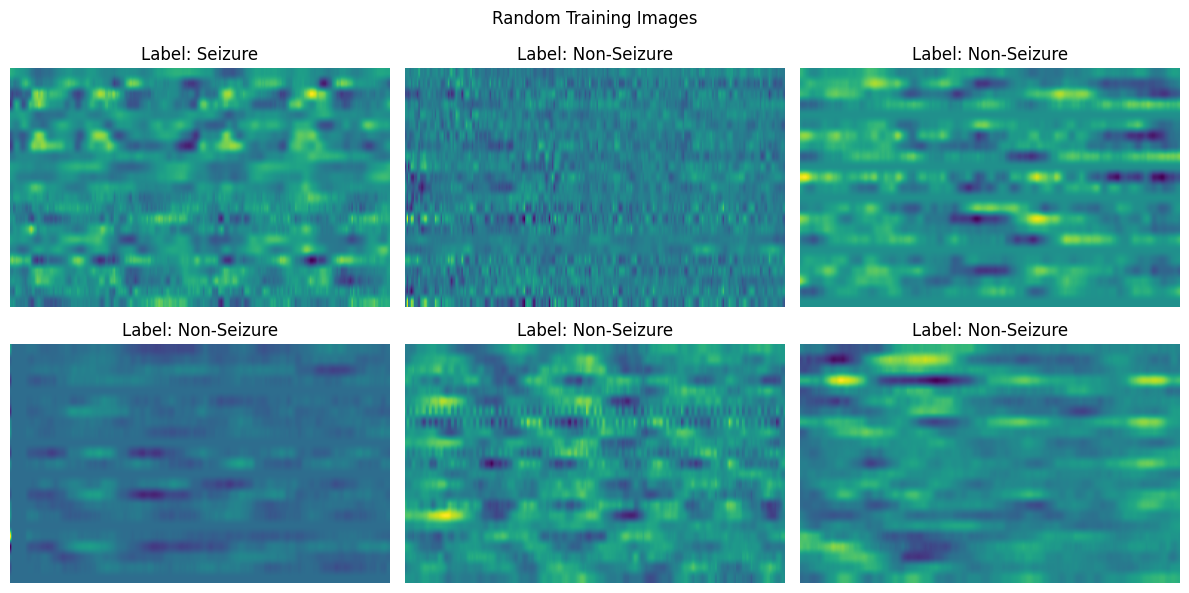

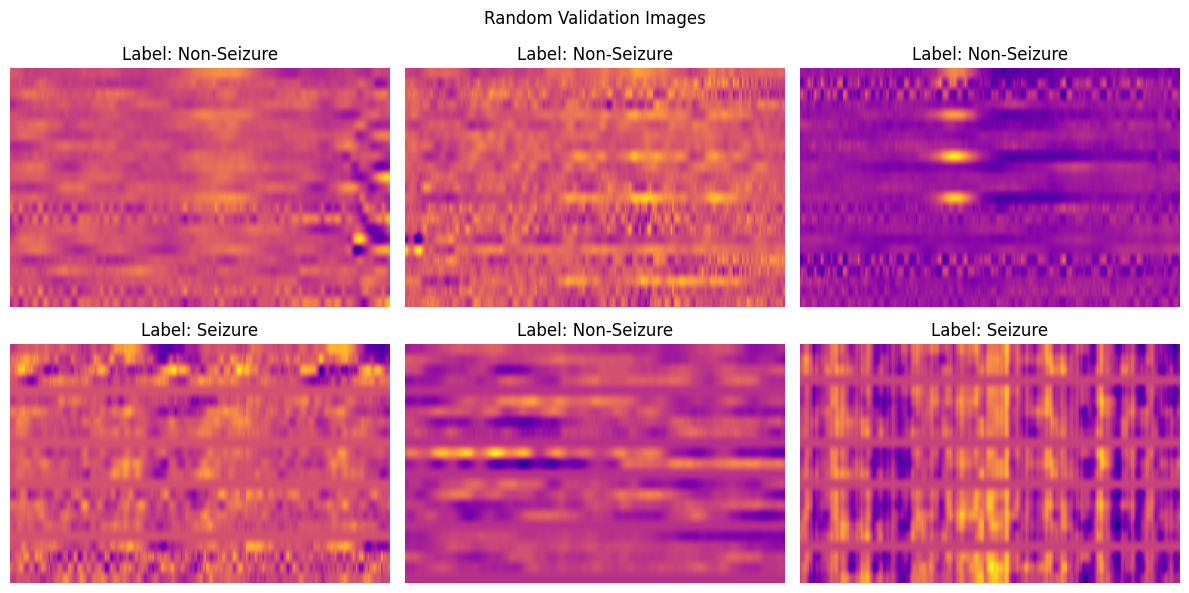

In [19]:
import seaborn as sns

# Generate random images and plots from test_data , val_data and test_data

def plot_random_images(data, labels, title, cmap='viridis'):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        index = np.random.randint(0, len(data))
        plt.subplot(2, 3, i + 1)
        plt.imshow(data[index].numpy().reshape(23, 256), cmap=cmap, aspect='auto')
        plt.title(f'Label: {"Seizure" if labels[index] else "Non-Seizure"}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display random images from training, validation, and test sets with different color maps
plot_random_images(X_train_cnn, y_train, 'Random Training Images', cmap='viridis')
plot_random_images(X_val_cnn, y_val, 'Random Validation Images', cmap='plasma')



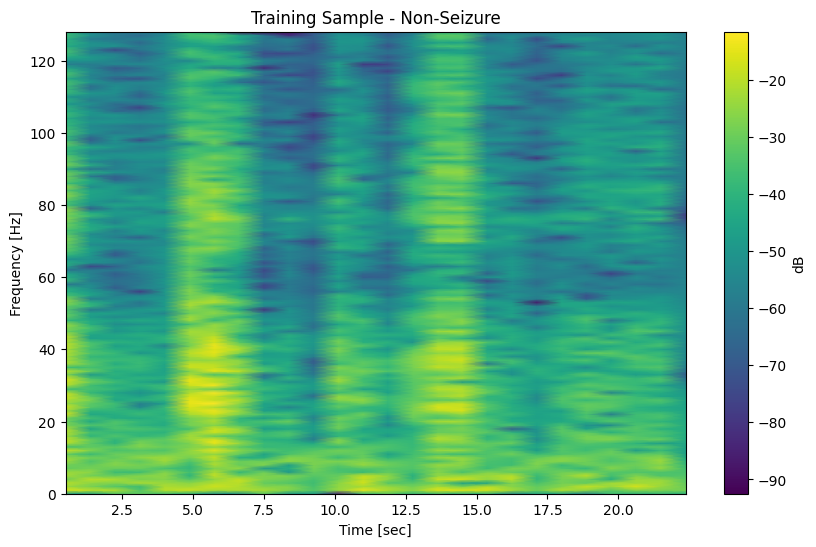

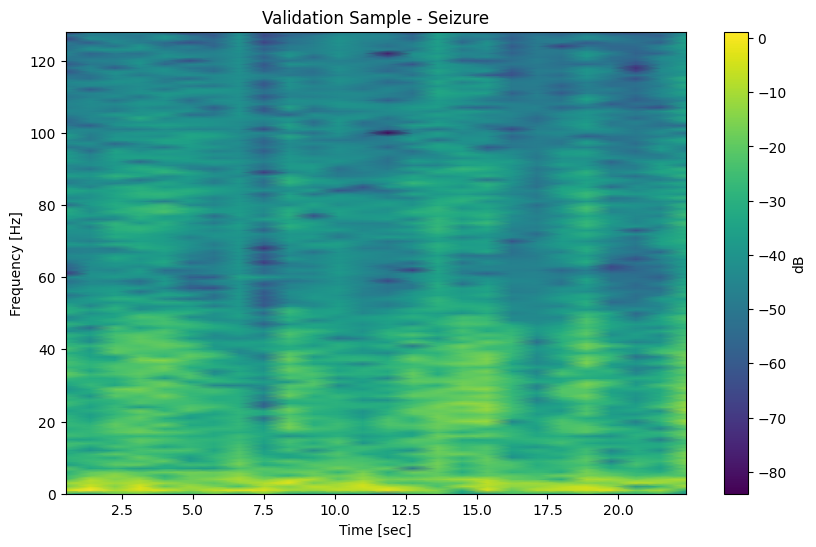

In [20]:
from scipy.signal import spectrogram

# Function to plot spectrogram
def plot_spectrogram(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    f, t, Sxx = spectrogram(data[index].numpy().flatten(), fs=256)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='dB')
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


# Plot spectrogram for random samples from training and validation sets
plot_spectrogram(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_spectrogram(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')




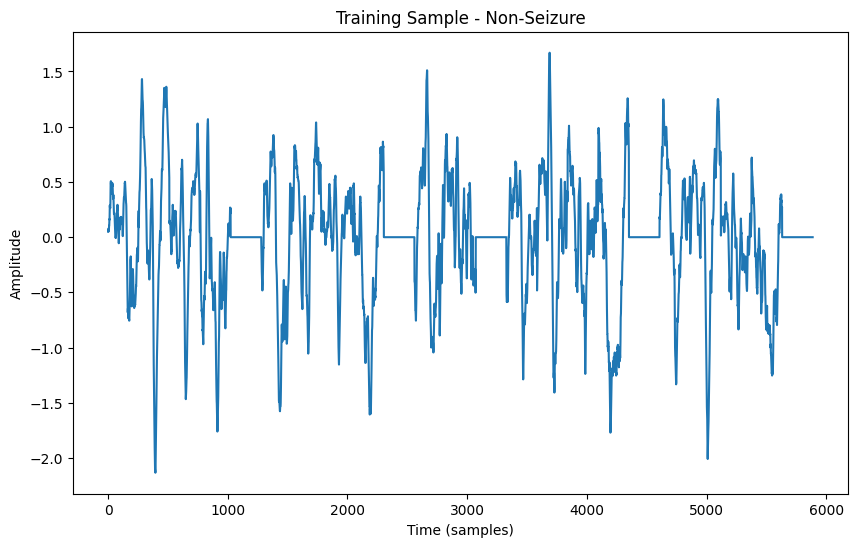

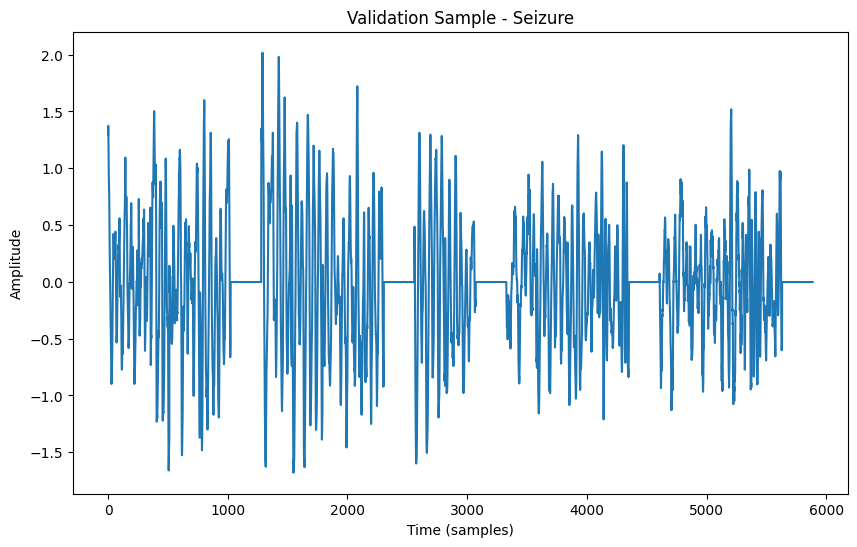

In [21]:
# Function to plot time-series data
def plot_time_series(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    plt.plot(data[index].numpy().flatten())
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

# Plot time-series data for random samples from training and validation sets
plot_time_series(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_time_series(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')

In [22]:

# Baseline model

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the baseline model
baseline_model_history = baseline_model.fit(datagen.flow(X_train_cnn, y_train, batch_size=32),
                                    epochs=20,
                                    validation_data=(X_val_cnn, y_val))

# Evalute the baseline_model

baseline_loss , baseline_accuracy = baseline_model.evaluate(X_val_cnn, y_val)
print(f'Baseline model Validation Accuracy {baseline_accuracy * 100:.2f}%')

# Generating classification report and confusion matrix for baseline model

baseline_y_pred = (baseline_model.predict(X_val_cnn) > 0.5).astype("int32")


print("Baseline model classification report:")
print(classification_report(y_val, baseline_y_pred))

print("Baseline model confusion matrix:")

print(confusion_matrix(y_val, baseline_y_pred))



Epoch 1/20
1178/1178 [==============================] - 38s 32ms/step - loss: 0.4848 - accuracy: 0.8055 - val_loss: 11.9425 - val_accuracy: 0.5169
Epoch 2/20
1178/1178 [==============================] - 37s 31ms/step - loss: 0.4698 - accuracy: 0.8155 - val_loss: 131.4384 - val_accuracy: 0.5000
Epoch 3/20
1178/1178 [==============================] - 37s 32ms/step - loss: 0.4632 - accuracy: 0.8171 - val_loss: 238.6416 - val_accuracy: 0.5000
Epoch 4/20
1178/1178 [==============================] - 37s 31ms/step - loss: 0.4620 - accuracy: 0.8167 - val_loss: 232.8087 - val_accuracy: 0.5000
Epoch 5/20
  22/1178 [..............................] - ETA: 35s - loss: 0.4548 - accuracy: 0.8168

KeyboardInterrupt: 

In [ ]:
# plot baseline model training and validation accuracy and loss values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(baseline_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(baseline_model_history.history['loss'], label='Training Loss')
plt.plot(baseline_model_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Baseline model summary

In [ ]:
print(baseline_model.summary())

##Choosing hyperparameter values :

1. Number of Filter('conv_1_filter','conv_2_filter'):

*   Range: between 32 - 128
*   Reason: Lower values may not capture sufficient features while too high values can lead to overfitting and high computational cost

2. Kernel Size (conv_1_kernel, conv_2_kernel):

*   between 3 - 5
*   Reason: Smaller kernel capture fine details while larger kernels capture more context.

3. Units in Dense Layer ('dense_1_units'):

*   b/w 32 - 128
*   Reason: This controls the complexity of the network. Too few units might underfit, and too many might overfit

4. Optimizer ('optimizer'):

*   'adam','sgd'
*   Reason:Adam is popular for its adaptive learning rate. SGD is simple and effective, often leading to good generalization.







In [23]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# Define focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * tf.keras.backend.pow((tf.ones_like(y_true) - p_t), gamma) * tf.keras.backend.log(p_t)
        return tf.keras.backend.mean(fl)
    return focal_loss_fixed



# Improved Model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(23, 256, 1), kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=focal_loss(), metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 21, 254, 64)       640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 127, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 10, 127, 64)       256       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 10, 127, 64)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 125, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 62, 128)       

In [29]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau # Import the missing class

# Calculate class weights
# Convert y_train to a NumPy array first
y_train_np = y_train.numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [31]:
history = model.fit(
    datagen.flow(X_train_cnn, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val_cnn, y_val),
    class_weight=class_weight_dict,
    callbacks=[reduce_lr]
)

Epoch 1/20
1178/1178 [==============================] - 90s 76ms/step - loss: 4.0005 - accuracy: 0.7642 - val_loss: 4.2229 - val_accuracy: 0.5031 - lr: 1.0000e-04
Epoch 2/20
1178/1178 [==============================] - 89s 76ms/step - loss: 1.4027 - accuracy: 0.7903 - val_loss: 6.2818 - val_accuracy: 0.5023 - lr: 1.0000e-04
Epoch 3/20
1178/1178 [==============================] - 89s 76ms/step - loss: 0.3832 - accuracy: 0.8021 - val_loss: 1.7152 - val_accuracy: 0.5620 - lr: 1.0000e-04
Epoch 4/20
1178/1178 [==============================] - 89s 75ms/step - loss: 0.0998 - accuracy: 0.8053 - val_loss: 2.0321 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/20
1178/1178 [==============================] - 90s 76ms/step - loss: 0.0570 - accuracy: 0.8074 - val_loss: 1.9020 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/20
1178/1178 [==============================] - 88s 75ms/step - loss: 0.0517 - accuracy: 0.8069 - val_loss: 0.9476 - val_accuracy: 0.5505 - lr: 1.0000e-04
Epoch 7/20
1178/1178 [

In [32]:
loss, accuracy = model.evaluate(X_val_cnn, y_val)
print(f'Improved Model Validation Accuracy {accuracy * 100:.2f}%')

# Generate classification report and confusion matrix
y_pred_probs = model.predict(X_val_cnn)
y_pred = (y_pred_probs > 0.5).astype("int32")
print("Improved Model classification report:")
print(classification_report(y_val, y_pred))
print("Improved Model confusion matrix:")
print(confusion_matrix(y_val, y_pred))


111/111 [==============================] - 2s 20ms/step - loss: 1.3309 - accuracy: 0.5516
Improved Model Validation Accuracy 55.16%
111/111 [==============================] - 2s 20ms/step
Improved Model classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.51      0.53      1773
         1.0       0.55      0.59      0.57      1773

    accuracy                           0.55      3546
   macro avg       0.55      0.55      0.55      3546
weighted avg       0.55      0.55      0.55      3546

Improved Model confusion matrix:
[[ 907  866]
 [ 724 1049]]


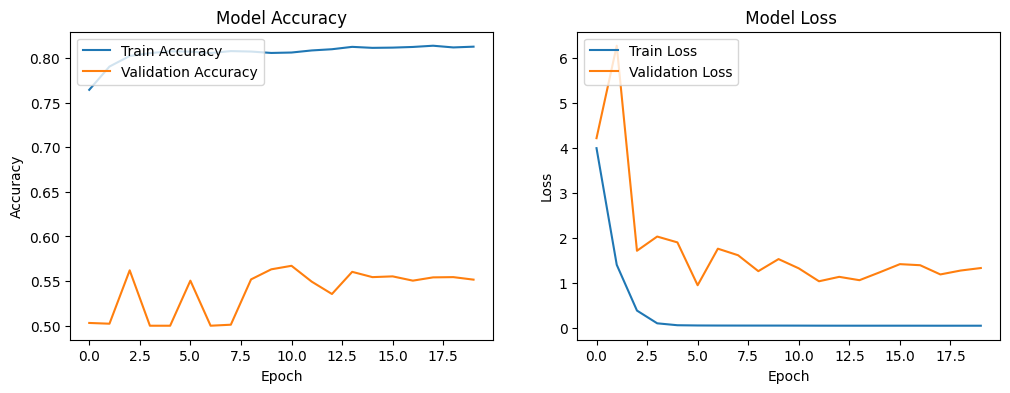

In [33]:
# plot tuned model training & validation accuracy and loss values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(' Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

## Comparing Both the models i.e Baseline model and Tuned Model

 Model Validation Accuracy 55.16%


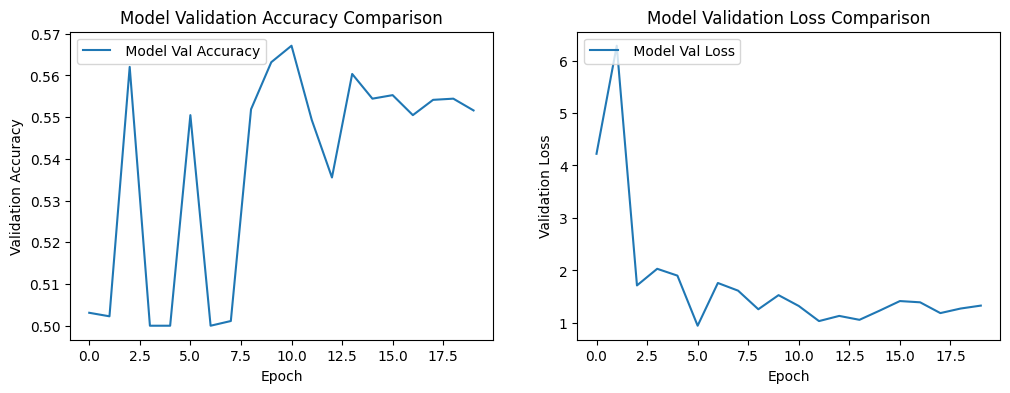

In [36]:
# print(f'Baseline Model Validation Accuracy {baseline_accuracy * 100:.2f}%')
print(f' Model Validation Accuracy {accuracy * 100:.2f}%')

# plot training & validation accuracy and loss values for both models

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

#plt.plot(baseline_model_history.history['val_accuracy'], label='Baseline Model Val Accuracy')

plt.plot(history.history['val_accuracy'], label=' Model Val Accuracy')

plt.title('Model Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(loc='upper left')


plt.subplot(1,2,2)
#plt.plot(baseline_model_history.history['val_loss'], label='Baseline Model Val Loss')
plt.plot(history.history['val_loss'], label=' Model Val Loss')
plt.title('Model Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(loc='upper left')

plt.show()

## Test the tuned model on random Samples

In [37]:
def test_random_samples(model, X_val_cnn , y_val , num_samples =100 ):
  indices = np.random.choice(len(X_val_cnn), num_samples, replace=False)
  for i in indices:
    sample = X_val_cnn[i]
    true_label = y_val[i]
    prediction = (model.predict(np.expand_dims(sample, axis=0)) > 0.5).astype("int32")

    print(f'True Label: {"Seizure" if true_label else "Non-Seizure"}, Prediction: {"Seizure" if prediction else "Non-Seizure"}')

test_random_samples(model, X_val_cnn, y_val)

1/1 [==============================] - 0s 28ms/step
True Label: Non-Seizure, Prediction: Seizure
1/1 [==============================] - 0s 27ms/step
True Label: Seizure, Prediction: Non-Seizure
1/1 [==============================] - 0s 25ms/step
True Label: Seizure, Prediction: Seizure
1/1 [==============================] - 0s 26ms/step
True Label: Seizure, Prediction: Seizure
1/1 [==============================] - 0s 26ms/step
True Label: Non-Seizure, Prediction: Seizure
1/1 [==============================] - 0s 26ms/step
True Label: Seizure, Prediction: Seizure
1/1 [==============================] - 0s 26ms/step
True Label: Seizure, Prediction: Non-Seizure
1/1 [==============================] - 0s 27ms/step
True Label: Non-Seizure, Prediction: Non-Seizure
1/1 [==============================] - 0s 26ms/step
True Label: Non-Seizure, Prediction: Non-Seizure
1/1 [==============================] - 0s 25ms/step
True Label: Non-Seizure, Prediction: Non-Seizure
1/1 [=========================

In [38]:
import pickle

# Save the model to a file
with open('Binary_Classification_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [40]:
from google.colab import files

# Assuming your file is named 'binary_classification_model.pkl'
files.download('Binary_Classification_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>